## Image Classification: Chinese vs Ghanaian Ethnicities 

This model uses Keras on Tensorflow and trains on over 1000 images to distinguish between Chinese and Ghanaian individuals. Images were scraped from Google. 


In [1]:
import os

#Dig into directories to put all files in a list
def list_files(path):
    r = []
    for root, dirs, files in os.walk(path):
        for name in files:
            r.append(os.path.join(root, name))
    return r

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img_path = './downloads/ethnicity'

#Get stats about all images we are training and testing on
def get_size_statistics(img_list):
    heights = []
    widths = []
    img_count = 0
    for img in img_list:
        if "DS_Store" not in img:
            try:
                data = np.array(Image.open(img))
                heights.append(data.shape[0])
                widths.append(data.shape[1])
                img_count += 1
            except (IOError, SyntaxError) as e:
                continue
    avg_height = sum(heights) / len(heights)
    avg_width = sum(widths) / len(widths)
    print("Average Height: " + str(avg_height))
    print("Max Height: " + str(max(heights)))
    print("Min Height: " + str(min(heights)))
    print('\n')
    print("Average Width: " + str(avg_width))
    print("Max Width: " + str(max(widths)))
    print("Min Width: " + str(min(widths)))
    print("Total Number of Images: "+ str(img_count))

get_size_statistics(list_files(img_path))

Average Height: 584.5699088145897
Max Height: 885
Min Height: 80


Average Width: 584.6724924012158
Max Width: 885
Min Width: 80
Total Number of Images: 1316


In [3]:
import cv2 as cv

faceCascade = cv.CascadeClassifier('./assets/haarcascade_frontalface_alt.xml')

#Clean data. Extract faces from photos.
def extract_faces(path):
    output = []
    r = list_files(path)
    for img_file in r:
        if "DS_Store" not in img_file:
            try:
                img_arr = np.array(Image.open(img_file))
                faces = faceCascade.detectMultiScale(img_arr)
                for (x, y, w, h) in faces:
                    face_found = img_arr[y:y + h, x:x + w]
                    img_im = Image.fromarray(face_found, 'RGB')
                    output.append((img_im,img_file))
            except(IOError, SyntaxError, ValueError) as e:
                continue
    return output

In [4]:
#Prepare images for face extraction and labelling

train_faces = extract_faces('downloads/ethnicity/train')
test_faces = extract_faces('downloads/ethnicity/test')

In [5]:
labels = [np.array([1,0]), np.array([0, 1])]

#Assigns a label based on which directory the image is in
def label_img(path, labels):
    if 'chinese'in path: return labels[0]
    elif 'ghanaian' in path: return labels[1]

In [6]:
import PIL

IMG_SIZE = 300

#Label and pack images into lists
def load_data(img_list):
    data = []
    for img_tup in img_list:
        try :
            label = label_img(img_tup[1], labels)
            img_data = img_tup[0].convert('L')
            img_data = img_data.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
            data.append([np.array(img_data), label])
        except (IOError, SyntaxError) as e:
            continue
    return data

Number of training images:  1014


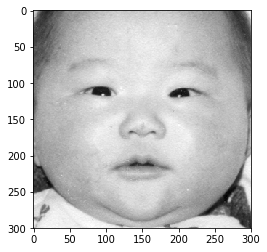

In [7]:
#Load training data

train_data = load_data(train_faces)
print("Number of training images: ", len(train_data))
plt.imshow(train_data[76][0], cmap = 'gist_gray')  

Number of testing images:  202


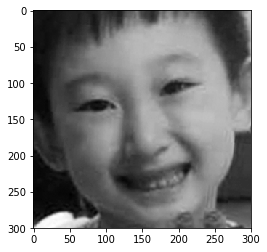

In [8]:
#Load testing Data

test_data = load_data(test_faces)
print("Number of testing images: ", len(test_data))
plt.imshow(test_data[13][0], cmap = 'gist_gray')  

In [9]:
#Reshapes image to fit given dimensions
def reshape(img):
    return img.reshape(IMG_SIZE, IMG_SIZE, 1)

##Vectorizes data and turn lists into arrays
def vectorize_data_set(data_set, index=0, edit=False):
    output = []
    for element in data_set:
        item = element[index]
        if edit:
            item = reshape(item)
        output.append(item)
    return np.array(output)

In [10]:
#Vectorize training and testing data

trainImages = vectorize_data_set(train_data, 0, True)
trainLabels = vectorize_data_set(train_data, 1, False)

testImages = vectorize_data_set(test_data, 0, True)
testLabels = vectorize_data_set(test_data, 1, False)

In [11]:
import keras
from keras import models
from keras import layers
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers. normalization import BatchNormalization

#The Keras model

model = models.Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation = 'softmax'))

model.summary()

C:\Users\moyed\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 149, 149, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 73, 73, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 96)        55392     
__________

In [12]:
from keras_tqdm import TQDMNotebookCallback

#Train the model

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.fit(trainImages, trainLabels, batch_size = 50, epochs = 5, verbose = 0, shuffle = True, callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)])

HBox(children=(IntProgress(value=0, description='Training', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=1014, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=1014, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=1014, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=1014, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=1014, style=ProgressStyle(description_width='initial')), HTML(value='')))

In [13]:
#Accuracy of test data on the model

test_loss, test_acc = model.evaluate(testImages, testLabels)
print("Evaluation accuracy",test_acc)

202/202 [==============================] - ETA: 15 - ETA: 12 - ETA: 9 - ETA:  - ETA:  - ETA:  - 21s 106ms/step
Evaluation accuracy 0.8613861374335714


In [14]:
#Save Model

model.save('./assets/ethnicity_model')

In [15]:
#Use model to predict ethnicity of image

def evaluate_img(model, img):
    result = vectorize_data_set([img], 0, True)
    result = model.predict(result, verbose=0)
    if result[0][0] > 0.5:
        print("Guess: Chinese with", result[0][0]*100,"% confidence.")
    else:
        print("Guess: Ghanaian with", (1- result[0][0]) * 100 ,"% confidence.")
    plt.imshow(img[0], cmap = 'gist_gray')
    

Guess: Chinese with 96.01922035217285 % confidence.


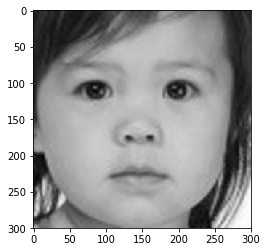

In [16]:
#Predict!

index = 26

evaluate_img(model, test_data[index])